# Optimization Using Gradient Descent in Two Variables

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from matplotlib.patches import FancyArrowPatch
from matplotlib.gridspec import GridSpec
from IPython.display import display, clear_output


def plot_f(x_range, y_range, f, ox_position):
    x = np.linspace(*x_range, 100)
    fig, ax = plt.subplots(1,1,figsize=(8,4))

    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.set_ylim(*y_range)
    ax.set_xlim(*x_range)
    ax.set_ylabel('$f$')
    ax.set_xlabel('$x$')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position(('data', ox_position))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.autoscale(enable=False)

    pf = ax.plot(x, f(x), 'k')

    return fig, ax


class gradient_descent_one_variable:
    """ class to run one interactive plot """
    def __init__(self, x_range, y_range, f, dfdx, gd, n_it, lr, x_0, ox_position, t_position):
        x = np.linspace(*x_range, 100)
        fig, ax = plot_f(x_range, y_range, f, ox_position)

        # Initialize plot.
        self.fig = fig
        self.ax = ax
        self.x = x
        self.f = f
        self.dfdx = dfdx
        self.gd = gd
        self.n_it = n_it
        self.lr = lr
        self.x_0 = x_0
        self.x_range = x_range
        self.i = 0
        self.ox_position = ox_position
        self.t_position = t_position

        self.update_plot_point(firsttime=True)
        self.path = path(self.x_0, self.ax, self.ox_position)  # initialize an empty path, avoids existance check

        time.sleep(0.2)
        clear_output(wait=True)
        display(self.fig)

        self.run_gd()
        self.cpoint = self.fig.canvas.mpl_connect('button_press_event', self.click_plot)

    def click_plot(self, event):
        ''' Called when click in plot '''
        if (event.xdata <= max(self.x) and event.xdata >= min(self.x)):
            self.x_0 = event.xdata
            self.i = 0
            self.path.re_init(self.x_0)
            self.update_plot_point()
            time.sleep(0.2)
            self.run_gd()

    def update_plot_point(self, firsttime=False):

        # Remove items and re-add them on plot.
        if not firsttime:
            for artist in self.p_items:
                artist.remove()

        a = self.ax.scatter(self.x_0, self.f(self.x_0), marker='o', s=100, color='r', zorder=10)
        b = self.ax.scatter(self.x_0, self.ox_position, marker='o', s=100, color='k', zorder=10)
        c = self.ax.hlines(self.f(self.x_0), 0, self.x_0, lw=2, ls='dotted', color='k')
        d = self.ax.vlines(self.x_0, self.ox_position, self.f(self.x_0), lw=2, ls='dotted', color='k')
        t_it = self.ax.annotate(f"Iteration #${self.i}$", xy=(self.t_position[0], self.t_position[1]),
                                xytext=(4,4), textcoords='offset points', size=10)
        t_x_0 = self.ax.annotate(f"$x_0 = {self.x_0:0.4f}$", xy=(self.t_position[0], self.t_position[1]-1),
                                 xytext=(4,4), textcoords='offset points', size=10)
        t_f = self.ax.annotate(f"$f\\,\\left(x_0\\right) = {self.f(self.x_0):0.2f}$",
                               xy=(self.t_position[0], self.t_position[1]-2), xytext=(4,4),
                              textcoords='offset points', size=10)
        t_dfdx = self.ax.annotate(f"$f\\,'\\left(x_0\\right) = {self.dfdx(self.x_0):0.4f}$",
                                  xy=(self.t_position[0], self.t_position[1]-3),
                                  xytext=(4,4), textcoords='offset points', size=10)

        self.p_items = [a, b, c, d, t_it, t_x_0, t_f, t_dfdx]
        self.fig.canvas.draw()

    def run_gd(self):
        self.i = 1
        x_0_new = self.gd(self.dfdx, self.x_0, self.lr, 1)
        while (self.i <= self.n_it and abs(self.dfdx(x_0_new)) >= 0.00001 and x_0_new >= self.x_range[0]):
            x_0_new = self.gd(self.dfdx, self.x_0, self.lr, 1)
            self.path.add_path_item(x_0_new, self.f)
            self.x_0 = x_0_new
            time.sleep(0.05)
            self.update_plot_point()
            clear_output(wait=True)
            display(self.fig)
            self.i += 1

        if abs(self.dfdx(self.x_0)) >= 0.00001 or self.x_0 < self.x_range[0] or self.x_0 < self.x_range[0]:
            t_res = self.ax.annotate("Has Not Converged", xy=(self.t_position[0], self.t_position[1]-4),
                             xytext=(4,4), textcoords='offset points', size=10)
        else:
            t_res = self.ax.annotate("Converged", xy=(self.t_position[0], self.t_position[1]-4),
                             xytext=(4,4), textcoords='offset points', size=10)
        t_instruction = self.ax.text(0.3,0.95,"[Click on the plot to choose initial point]",
                                     size=10, color="r", transform=self.ax.transAxes)
        self.p_items.append(t_res)
        self.p_items.append(t_instruction)
        # Clear last time at the end, so there is no duplicate with the cell output.
        clear_output(wait=True)
#         plt.close()


class path:
    ''' tracks paths during gradient descent on the plot '''
    def __init__(self, x_0, ax, ox_position):
        ''' x_0 at start of path '''
        self.path_items = []
        self.x_0 = x_0
        self.ax = ax
        self.ox_position = ox_position

    def re_init(self, x_0):
        for artist in self.path_items:
            artist.remove()
        self.path_items = []
        self.x_0 = x_0

    def add_path_item(self, x_0, f):
        a = FancyArrowPatch(
            posA=(self.x_0, self.ox_position), posB=(x_0, self.ox_position), color='r',
            arrowstyle='simple, head_width=5, head_length=10, tail_width=1.0',
        )
        b = self.ax.scatter(self.x_0, f(self.x_0), facecolors='none', edgecolors='r', ls='dotted', s=100, zorder=10)
        self.ax.add_artist(a)
        self.path_items.append(a)
        self.path_items.append(b)
        self.x_0 = x_0


# +
def f_example_2(x):
    return (np.exp(x) - np.log(x))*np.sin(np.pi*x*2)

def dfdx_example_2(x):
    return (np.exp(x) - 1/x)*np.sin(np.pi*x*2) + (np.exp(x) - \
              np.log(x))*np.cos(np.pi*x*2)*2*np.pi


# +
def f_example_3(x,y):
    return (85+ 0.1*(- 1/9*(x-6)*x**2*y**3 + 2/3*(x-6)*x**2*y**2))

def dfdx_example_3(x,y):
    return 0.1/3*x*y**2*(2-y/3)*(3*x-12)

def dfdy_example_3(x,y):
    return 0.1/3*(x-6)*x**2*y*(4-y)


# +
def f_example_4(x,y):
    return -(10/(3+3*(x-.5)**2+3*(y-.5)**2) + \
            2/(1+2*((x-3)**2)+2*(y-1.5)**2) + \
            3/(1+.5*((x-3.5)**2)+0.5*(y-4)**2))+10

def dfdx_example_4(x,y):
    return  -(-2*3*(x-0.5)*10/(3+3*(x-0.5)**2+3*(y-0.5)**2)**2 + \
            -2*2*(x-3)*2/(1+2*((x-3)**2)+2*(y-1.5)**2)**2 +\
            -2*0.5*(x-3.5)*3/(1+.5*((x-3.5)**2)+0.5*(y-4)**2)**2)

def dfdy_example_4(x,y):
    return -(-2*3*(y-0.5)*10/(3+3*(x-0.5)**2+3*(y-0.5)**2)**2 + \
            -2*2*(y-1.5)*2/(1+2*((x-3)**2)+2*(y-1.5)**2)**2 +\
            -0.5*2*(y-4)*3/(1+.5*((x-3.5)**2)+0.5*(y-4)**2)**2)


# -

def plot_f_cont_and_surf(x_range, y_range, z_range, f, cmap, view):

    fig = plt.figure( figsize=(10,5))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.set_facecolor('#ffffff') #white
    gs = GridSpec(1, 2, figure=fig)
    axc = fig.add_subplot(gs[0, 0])
    axs = fig.add_subplot(gs[0, 1],  projection='3d')

    x = np.linspace(*x_range, 51)
    y = np.linspace(*y_range, 51)
    X,Y = np.meshgrid(x,y)

    cont = axc.contour(X, Y, f(X, Y), cmap=cmap, levels=18, linewidths=2, alpha=0.7)
    axc.set_xlabel('$x$')
    axc.set_ylabel('$y$')
    axc.set_xlim(*x_range)
    axc.set_ylim(*y_range)
    axc.set_aspect("equal")
    axc.autoscale(enable=False)

    surf = axs.plot_surface(X,Y, f(X,Y), cmap=cmap,
                    antialiased=True, cstride=1, rstride=1, alpha=0.69)
    axs.set_xlabel('$x$')
    axs.set_ylabel('$y$')
    axs.set_zlabel('$f$')
    axs.set_xlim(*x_range)
    axs.set_ylim(*y_range)
    axs.set_zlim(*z_range)
    axs.view_init(elev=view['elev'], azim=view['azim'])
    axs.autoscale(enable=False)

    return fig, axc, axs


class gradient_descent_two_variables:
    """ class to run one interactive plot """
    def __init__(self, x_range, y_range, z_range, f, dfdx, dfdy, gd, n_it, lr, x_0, y_0,
                 t_position, t_space, instr_position, cmap, view):

        x = np.linspace(*x_range, 51)
        y = np.linspace(*y_range, 51)
        fig, axc, axs = plot_f_cont_and_surf(x_range, y_range, z_range, f, cmap, view)

        # Initialize plot.
        self.fig = fig
        self.axc = axc
        self.axs = axs
        self.x = x
        self.y = y
        self.f = f
        self.dfdx = dfdx
        self.dfdy = dfdy
        self.gd = gd
        self.n_it = n_it
        self.lr = lr
        self.x_0 = x_0
        self.y_0 = y_0
        self.x_range = x_range
        self.y_range = y_range
        self.i = 0
        self.t_position = t_position
        self.t_space = t_space
        self.instr_position = instr_position

        self.update_plot_point(firsttime=True)
        self.path = path_2(self.x_0, self.y_0, self.axc, self.axs)  # initialize an empty path, avoids existance check

        time.sleep(0.2)
        clear_output(wait=True)
        display(self.fig)

        self.run_gd()
        self.cpoint = self.fig.canvas.mpl_connect('button_press_event', self.click_plot)

    def click_plot(self, event):
        ''' Called when click in plot '''
        if (event.xdata <= max(self.x) and event.xdata >= min(self.x) and
            event.ydata <= max(self.y) and event.ydata >= min(self.y)):
            self.x_0 = event.xdata
            self.y_0 = event.ydata
            self.i = 0
            self.path.re_init(self.x_0, self.y_0)
            self.update_plot_point()
            time.sleep(0.2)
            self.run_gd()

    def update_plot_point(self, firsttime=False):

        # Remove items and re-add them on plot.
        if not firsttime:
            for artist in self.p_items:
                artist.remove()

        a = self.axc.scatter(self.x_0, self.y_0, marker='o', s=100, color='k', zorder=10)
        b = self.axc.hlines(self.y_0, self.axc.get_xlim()[0], self.x_0, lw=2, ls='dotted', color='k')
        c = self.axc.vlines(self.x_0, self.axc.get_ylim()[0], self.y_0, lw=2, ls='dotted', color='k')
        d = self.axs.scatter3D(self.x_0, self.y_0, self.f(self.x_0, self.y_0), s=100, color='r', zorder=10)
        t_it = self.axs.text(self.t_position[0], self.t_position[1], self.t_position[2],
                             f"Iteration #${self.i}$", size=10, zorder=20)
        t_x_y = self.axs.text(self.t_position[0], self.t_position[1], self.t_position[2]-self.t_space,
                             f"$x_0, y_0 = {self.x_0:0.2f}, {self.y_0:0.2f}$", size=10, zorder=20)
        t_f = self.axs.text(self.t_position[0], self.t_position[1], self.t_position[2]-self.t_space*2,
                             f"$f\\,\\left(x_0, y_0\\right) = {self.f(self.x_0, self.y_0):0.2f}$", size=10, zorder=20)
        t_dfdx = self.axs.text(self.t_position[0], self.t_position[1], self.t_position[2]-self.t_space*3,
                             f"$f\\,'_x\\left(x_0, y_0\\right) = {self.dfdx(self.x_0, self.y_0):0.2f}$", size=10, zorder=20)
        t_dfdy = self.axs.text(self.t_position[0], self.t_position[1], self.t_position[2]-self.t_space*4,
                             f"$f\\,'_y\\left(x_0, y_0\\right) = {self.dfdy(self.x_0, self.y_0):0.2f}$", size=10, zorder=20)
        self.p_items = [a, b, c, d, t_it, t_x_y, t_f, t_dfdx, t_dfdy]
        self.fig.canvas.draw()

    def run_gd(self):
        self.i = 1
        x_0_new, y_0_new = self.gd(self.dfdx, self.dfdy, self.x_0, self.y_0, self.lr, 1)

        while (self.i <= self.n_it and
               (abs(self.dfdx(x_0_new, y_0_new)) >= 0.001 or abs(self.dfdy(x_0_new, y_0_new)) >= 0.001) and
               x_0_new >= self.x_range[0] and x_0_new <= self.x_range[1] and
               y_0_new >= self.y_range[0] and y_0_new <= self.y_range[1]):
            x_0_new, y_0_new = self.gd(self.dfdx, self.dfdy, self.x_0, self.y_0, self.lr, 1)
            self.path.add_path_item(x_0_new, y_0_new, self.f)
            self.x_0 = x_0_new
            self.y_0 = y_0_new
            time.sleep(0.05)
            self.update_plot_point()
            clear_output(wait=True)
            display(self.fig)
            self.i += 1

        if abs(self.dfdx(x_0_new, y_0_new)) >= 0.001 or abs(self.dfdy(x_0_new, y_0_new)) >= 0.001 or self.x_0 < self.x_range[0] or self.x_0 > self.x_range[1] or self.y_0 < self.y_range[0] or self.y_0 > self.y_range[1]:
            t_res = self.axs.text(self.t_position[0], self.t_position[1], self.t_position[2]-self.t_space*5,
                                  "Has Not Converged", size=10, zorder=20)
        else:
            t_res = self.axs.text(self.t_position[0], self.t_position[1], self.t_position[2]-self.t_space*5,
                                  "Converged", size=10, zorder=20)
        t_instruction = self.axs.text(*self.instr_position, "[Click on the contour plot to choose initial point]",
                                     size=10, color="r", transform=self.axs.transAxes)
        self.p_items.append(t_res)
        self.p_items.append(t_instruction)
        # Clear last time at the end, so there is no duplicate with the cell output.
        clear_output(wait=True)


class path_2:
    ''' tracks paths during gradient descent on contour and surface plots '''
    def __init__(self, x_0, y_0, axc, axs):
        ''' x_0, y_0 at start of path '''
        self.path_items = []
        self.x_0 = x_0
        self.y_0 = y_0
        self.axc = axc
        self.axs = axs

    def re_init(self, x_0, y_0):
        for artist in self.path_items:
            artist.remove()
        self.path_items = []
        self.x_0 = x_0
        self.y_0 = y_0

    def add_path_item(self, x_0, y_0, f):
        a = FancyArrowPatch(
            posA=(self.x_0, self.y_0), posB=(x_0, y_0), color='r',
            arrowstyle='simple, head_width=5, head_length=10, tail_width=1.0',
        )
        b = self.axs.scatter3D(self.x_0, self.y_0, f(self.x_0, self.y_0),
                               facecolors='none', edgecolors='r', ls='dotted', s=100, zorder=10)
        self.axc.add_artist(a)
        self.path_items.append(a)
        self.path_items.append(b)
        self.x_0 = x_0
        self.y_0 = y_0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Some functions defined specifically for this notebook.
#from w2_tools import (plot_f_cont_and_surf, gradient_descent_two_variables,
#                      f_example_3, dfdx_example_3, dfdy_example_3,
#                      f_example_4, dfdx_example_4, dfdy_example_4)
# Magic command to make matplotlib plots interactive.
#%matplotlib widget

<a name='1'></a>
## 1 - Function with One Global Minimum

Let's explore a simple example of a function in two variables $f\left(x, y\right)$ with one global minimum. Such a function was discussed in the videos, it is predefined and uploaded into this notebook as `f_example_3` with its partial derivatives `dfdx_example_3` and `dfdy_example_3`. At this stage, you do not need to worry about the exact expression for that function and its partial derivatives, so you can focus on the implementation of gradient descent and the choice of the related parameters. Run the following cell to plot the function.

(<Figure size 1000x500 with 2 Axes>,
 <Axes: xlabel='$x$', ylabel='$y$'>,
 <Axes3D: xlabel='$x$', ylabel='$y$', zlabel='$f$'>)

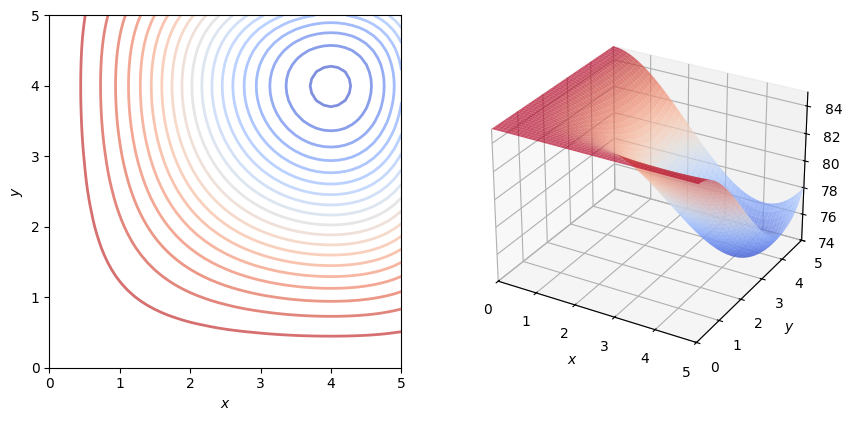

In [3]:
plot_f_cont_and_surf([0, 5], [0, 5], [74, 85], f_example_3, cmap='coolwarm', view={'azim':-60,'elev':28})

To find the minimum, you can implement gradient descent starting from the initial point $\left(x_0, y_0\right)$ and making steps iteration by iteration using the following equations:


$$x_1 = x_0 - \alpha \frac{\partial f}{\partial x}(x_0, y_0),$$
$$y_1 = y_0 - \alpha \frac{\partial f}{\partial y}(x_0, y_0),\tag{1}$$

where $\alpha>0$ is a learning rate. Number of iterations is also a parameter. The method is implemented with the following code:

In [4]:
def gradient_descent(dfdx, dfdy, x, y, learning_rate = 0.1, num_iterations = 100):
    for iteration in range(num_iterations):
        x, y = x - learning_rate * dfdx(x, y), y - learning_rate * dfdy(x, y)
    return x, y

Now to optimize the function, set up the parameters `num_iterations`, `learning_rate`, `x_initial`, `y_initial` and run gradient descent:

In [5]:
num_iterations = 30; learning_rate = 0.25; x_initial = 0.5; y_initial = 0.6
print("Gradient descent result: x_min, y_min =",
      gradient_descent(dfdx_example_3, dfdy_example_3, x_initial, y_initial, learning_rate, num_iterations))

Gradient descent result: x_min, y_min = (4.0, 4.0)


You can see the visualization running the following code. Note that gradient descent in two variables performs steps on the plane, in a direction opposite to the gradient vector $\begin{bmatrix}\frac{\partial f}{\partial x}(x_0, y_0) \\ \frac{\partial f}{\partial y}(x_0, y_0)\end{bmatrix}$ with the learning rate $\alpha$ as a scaling factor.

By uncommenting different lines you can experiment with various sets of the parameter values and corresponding results. At the end of the animation, you can also click on the contour plot to choose the initial point and restart the animation automatically.

Run a few experiments and try to explain what is actually happening in each of the cases.

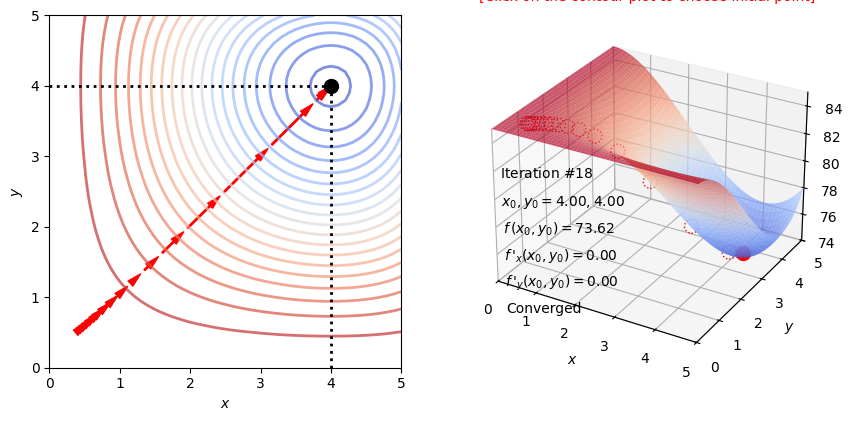

In [6]:
num_iterations = 20; learning_rate = 0.25; x_initial = 0.5; y_initial = 0.6
# num_iterations = 20; learning_rate = 0.5; x_initial = 0.5; y_initial = 0.6
# num_iterations = 20; learning_rate = 0.15; x_initial = 0.5; y_initial = 0.6
# num_iterations = 20; learning_rate = 0.15; x_initial = 3.5; y_initial = 3.6

gd_example_3 = gradient_descent_two_variables([0, 5], [0, 5], [74, 85],
                                              f_example_3, dfdx_example_3, dfdy_example_3,
                                              gradient_descent, num_iterations, learning_rate,
                                              x_initial, y_initial,
                                              [0.1, 0.1, 81.5], 2, [4, 1, 171],
                                              cmap='coolwarm', view={'azim':-60,'elev':28})

<a name='2'></a>
## 2 - Function with Multiple Minima

Let's investigate a more complicated case of a function, which was also shown in the videos:

(<Figure size 1000x500 with 2 Axes>,
 <Axes: xlabel='$x$', ylabel='$y$'>,
 <Axes3D: xlabel='$x$', ylabel='$y$', zlabel='$f$'>)

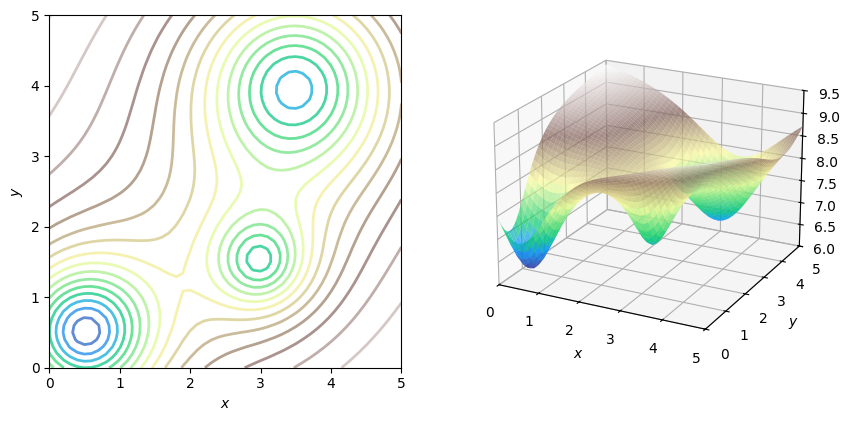

In [7]:
plot_f_cont_and_surf([0, 5], [0, 5], [6, 9.5], f_example_4, cmap='terrain', view={'azim':-63,'elev':21})

You can find its global minimum point by using gradient descent with the following parameters:

In [8]:
num_iterations = 100; learning_rate = 0.2; x_initial = 0.5; y_initial = 3

print("Gradient descent result: x_min, y_min =",
      gradient_descent(dfdx_example_4, dfdy_example_4, x_initial, y_initial, learning_rate, num_iterations))

Gradient descent result: x_min, y_min = (0.5230322579358745, 0.5169891562802605)


However, the shape of the surface is much more complicated and not every initial point will bring you to the global minimum of this surface. Use the following code to explore various sets of parameters and the results of gradient descent.

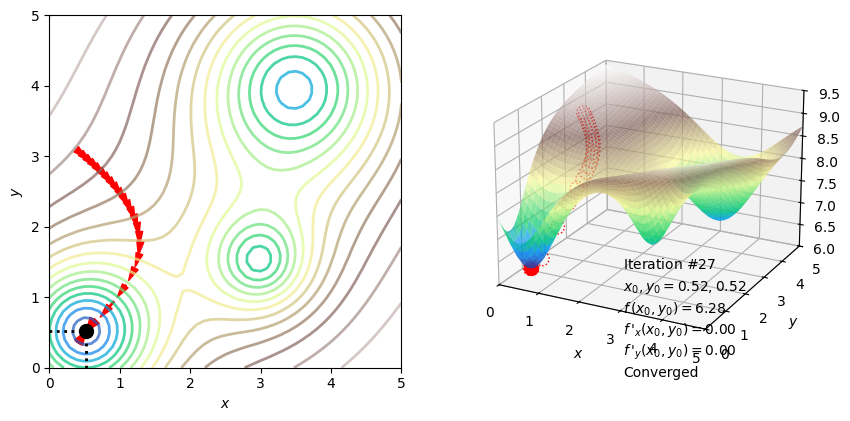

In [9]:
# Converges to the global minimum point.
num_iterations = 30; learning_rate = 0.2; x_initial = 0.5; y_initial = 3
# Converges to a local minimum point.
# num_iterations = 20; learning_rate = 0.2; x_initial = 2; y_initial = 3
# Converges to another local minimum point.
# num_iterations = 20; learning_rate = 0.2; x_initial = 4; y_initial = 0.5

gd_example_4 = gradient_descent_two_variables([0, 5], [0, 5], [6, 9.5],
                                              f_example_4, dfdx_example_4, dfdy_example_4,
                                              gradient_descent, num_iterations, learning_rate,
                                              x_initial, y_initial,
                                              [2, 2, 6], 0.5, [2, 1, 63],
                                              cmap='terrain', view={'azim':-63,'elev':21})